# Modeling the Glucose-Insulin system

#### Bonnie Cooper
<br><br>  

## DATA604 Summer 2020 Final Exam
&nbsp;&nbsp;&nbsp;&nbsp;This notebook implements the code and executes the exercises for [chap17.ipynb](https://github.com/SmilodonCub/ModSimPy/blob/master/notebooks/chap17.ipynb) and [chap18.ipynb](https://github.com/SmilodonCub/ModSimPy/blob/master/notebooks/chap18.ipynb) notebooks


### The Glucose Minimal Model
&nbsp;&nbsp;&nbsp;&nbsp;The Minimal Model is a model in two parts: the glucose model and the insulin model. First described by Bergman *et al* (1), the model seeks 'the simplest model based on known physiology that could account for the insulin-glucose relationship revealed in the data.' The goal of this model is to estimate the model parameters given a dataset and to be able to interpret the model parameters meanigfully. Blood glucose levels are modeled to decrease in the blood due to two main effects: the blood glucose's natural tendancy to normalize in concentraion and the effects of insulin. Insulin is found to have a relatively longer latency to action.  

The Glucose Minimal Model consists of 2 differential equations:

1. $$ \frac{dG}{dt} = -k_1[G(t) - G_b] - X(t)G(t)$$
2. $$ \frac{dX}{dt} = k_3[I(t) - I_b] - k_2X(t)$$ 

where  
* $G$ [ blood glucose ] as a function of time
* $X$ [ insulin ] as a function of time
* $I$ [ insulin ] as a function of time measured from the patient
* $G_b$ & $I_b$ [ blood glucose ] & [ insulin ] basal at equilibrium
* $\frac{dG}{dt}$ & $\frac{dX}{dt}$ rates of change
* $k_1$, $K_2$ and $k_3$ model parameters

We can interpret the equations as follows:
1. the rate of change of blood glucose concentration as a function of time can be described by the rate of glucose disappearance due to the effects of glucose itself and the rate of glucose disappearance due to the effects of insulin
2. the rate of change of blood insulin concentration as a function of time can be described by the rate that insulin diffuses from blood to interstitial fluid and the rate that insulin is broken down in tissue.

### the Data

To implement the Minimal Model for Glucose, data from Pacini & Bergman (3) will be used.
<br><br>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read data to a pandas dataframe
data = pd.read_csv( 'https://raw.githubusercontent.com/SmilodonCub/ModSimPy/master/notebooks/data/glucose_insulin.csv', index_col='time' )
data.head()

,glucose,insulin
time,,
0,92,11
2,350,26
4,287,130
6,251,85
8,240,51


<br>
The following code visualizes the Pacini & Bergman data:  
<br>  


Text(0.5, -0.05, 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity')

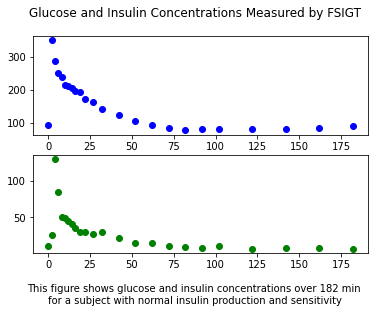

In [3]:
txt = 'This figure shows glucose and insulin concentrations over 182 min \nfor a subject with normal insulin production and sensitivity'
fig, axs = plt.subplots(2);
fig.suptitle('Glucose and Insulin Concentrations Measured by FSIGT');
axs[0].plot(data.index, data['glucose'], 'ob');
axs[1].plot(data.index, data['insulin'], 'og');
fig.text(.5, -0.05, txt, ha='center')

<br>  
### Interpolation
&nbsp;&nbsp;&nbsp;&nbsp;The Pacini & Bergman data is a series of discrete timepoint measurements. However, it may be necessary to estimate timepoints that occu inbetween the provided data points. For this purpose, the data points need to be interpolated.  
&nbsp;&nbsp;&nbsp;&nbsp;**Interpolation** is a mathematical technique that estimates values inbetween the given data points. There are several popular interpolation methods, the simplest of which is linear interpolation. linear interpolation calculates the slope between two adjacent data points and uses this to extimate points that lay in between. The following code applies linear interpolation to the dataset & visualizes the result.
<br><br>

In [4]:
from scipy import interpolate as int
import numpy as np

In [5]:
I = int.interp1d( data.index, data.insulin, kind = 'linear')
G = int.interp1d( data.index, data.glucose, kind = 'linear')

Text(0.03, 0.3, 'Concentration ($\\mu$U/mL)')

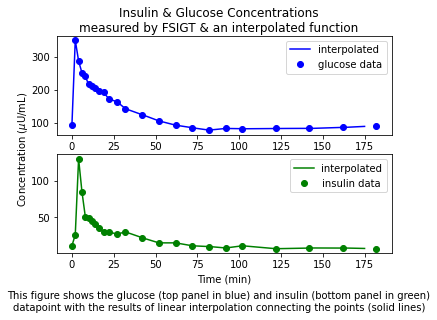

In [6]:
ts = np.linspace( 0, 175, num = 176, endpoint=True )

fig, axs = plt.subplots(2);
fig.suptitle('Insulin & Glucose Concentrations\nmeasured by FSIGT & an interpolated function');
axs[1].plot( ts, I(ts), 'g', label = 'interpolated');
axs[1].plot( data.index, data['insulin'], 'og', label = 'insulin data');
axs[1].legend()
axs[1].set_xlabel('Time (min)')
axs[0].plot( ts, G(ts), 'b', label = 'interpolated');
axs[0].plot( data.index, data['glucose'], 'ob', label = 'glucose data');
axs[0].legend();
txt = 'This figure shows the glucose (top panel in blue) and insulin (bottom panel in green)\ndatapoint with the results of linear interpolation connecting the points (solid lines)'
fig.text(.5, -0.075, txt, ha='center')
txt2 = 'Concentration ($\mu$U/mL)'
fig.text(0.03, 0.3, txt2,rotation='vertical')

<br>  
&nbsp;&nbsp;&nbsp;&nbsp;The `interp1d` function from the `scipy` package was used to perform the linear interpolation of the dataset. However, `interp1d` has several other interpolation methods that may be called: ‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, and ‘next’. The following code will implement quadratic interpolation. Quadratic interpolation introduces curvature to the estimate by minimizing the fit of a quadratic equation to three datapoints.
<br>  
<br>

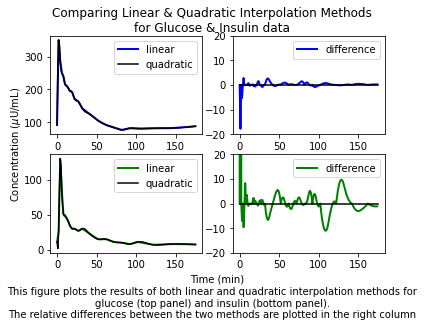

In [7]:
I2 = int.interp1d( data.index, data.insulin, kind = 'quadratic')
G2 = int.interp1d( data.index, data.glucose, kind = 'quadratic')
I_diff = (I(ts)-I2(ts))/I2(ts)*100
G_diff = (G(ts)-G2(ts))/G2(ts)*100

fig = plt.figure();
axBig = fig.add_subplot(111)
axBig.spines['top'].set_color('none')
axBig.spines['bottom'].set_color('none')
axBig.spines['left'].set_color('none')
axBig.spines['right'].set_color('none')
axBig.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
fig.suptitle('Comparing Linear & Quadratic Interpolation Methods\nfor Glucose & Insulin data');
axBig.set_xlabel('Time (min)')
axBig.set_ylabel('Concentration ($\mu$U/mL)')
ax0 = fig.add_subplot(221)
ax0.plot( ts, G(ts), 'b', linewidth=2, label = 'linear');
ax0.plot( ts, G2(ts), 'k', label = 'quadratic');
ax0.legend();
ax1 = fig.add_subplot(223)
ax1.plot( ts, I(ts), 'g', linewidth=2, label = 'linear');
ax1.plot( ts, I2(ts), 'k', label = 'quadratic');
ax1.legend()
ax2 = fig.add_subplot(224)
ax2.plot( ts[0:-1], I_diff[0:-1], 'g', linewidth=2, label = 'difference');
ax2.plot( ts, np.zeros(len(ts)), 'k');
ax2.set_ylim([-20, 20])
ax2.legend()
ax3 = fig.add_subplot(222)
ax3.plot( ts[0:-1], G_diff[0:-1], 'b', linewidth=2, label = 'difference');
ax3.plot( ts, np.zeros(len(ts)), 'k');
ax3.set_ylim([-20, 20])
ax3.legend();
txt = 'This figure plots the results of both linear and quadratic interpolation methods for\nglucose (top panel) and insulin (bottom panel).\nThe relative differences between the two methods are plotted in the right column'
fig.text(.5, -0.10, txt, ha='center');

<br>  
&nbsp;&nbsp;&nbsp;&nbsp;The figure above plots the linear and quadratic interpolations of the data in the left hand column for blood glucose concentration (top panel) and blood insulin concentration (bottom panel). The envelope of the linear and quadratic series are very similar. To highlight the differences, the subplots in the right hand column show the relative differences for glucose and insulin interpolations (top and bottom figures respectively) by linear and quadratic methods.
<br><br>

In [8]:
diff = G(ts) - G2(ts)
percent_diff = diff / G2(ts) * 100
maxG = max(abs(percent_diff[5:-1]))

diff = I(ts) - I2(ts)
percent_diff = diff / I2(ts) * 100
maxI = max(abs(percent_diff[5:-1]))

print( 'Max relative difference Glucose:', round(maxG,2), '%\nMax relative difference Insulin:', round(maxI,2), '%' )

Max relative difference Glucose: 2.81 %
Max relative difference Insulin: 11.01 %


&nbsp;&nbsp;&nbsp;&nbsp;The differences between linear and quadratic interpolation methods have very pronounced differences towards the begining of the data series and this is not surprising given the sharp data peak there. However, if the first 5 interpolation values are omitted (which represent estimates for and between the first 3 points of the original data series), we see that there is little difference between the linear and quadratic interpolation results for both glucose and insulin data (2.81% and 11.01% respectively)

## The Glucose Model

&nbsp;&nbsp;&nbsp;&nbsp;The previous sections dealt with various interpolation methods to estimate values inbetween the provided datapoints. The following code will implement the minimal model of blood glucose levels by finding numerical solutions to the minimal model differential equations using two methods: Euler's method & Ralston's method. Euler's method evaluates the derivative of the system equations at discrete time intervals, so in this sense, it is a 1st order solution and really only very accurate to the 1st derivative. The Euler method can only yield an exact solutiion for linear problems. Ralston's method, on the other hand, is a second order solution and more advanced in that it involves an intermediate slope calculation. The slope calculation takes an intermediate value into account and therefore reduces the truncation error introduced to the numerical solution. Truncation error refers to the error incurred by discretizing data. Ralston's method is one in a family of Runge-Kutta methods that may have higher order solutions (accounting for higher order derivatives). The higher the order, the better a solution the complex series. In other words, the wavier and more irregular the data are better described by higher order methods. However, simple data series can be adequately described by Euler (1st order) and Ralston's (2nd order).  

### Euler's Method

&nbsp;&nbsp;&nbsp;&nbsp;Define python objects and functions to implement Euler's numerical solution:
<br><br>

In [9]:
class Params:
    """ Params class represents a collection of parameters. """

    def __init__(self, G0, k1, k2, k3):
        """ Create a new set of parameters """
        self.G0 = G0
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3
        
class State:
    """State class represents the current state of the minimal model"""
    
    def __init__( self, G, X ):
        """Initialize State"""
        self.G = G
        self.X = X
        
class System:
    """Sytem class represents the minimal model system"""
    
    def __init__( self, params, initState, Gb, Ib, I, t_0, t_end, dt, k1, k2, k3 ):
        """Initialize System"""
        self.params = params
        self.initState = initState
        self.Gb = Gb
        self.Ib = Ib
        self.I = I
        self.t_0 = t_0
        self.t_end = t_end
        self.dt = dt
        self.k1 = k1
        self.k2 = k2
        self.k3 = k3

In [10]:
def make_system( params, data, timeStep ):
    """
    uses initial measurements from params & data to initialize a system
    params: a Params object
    data: a pandas dataframe
    timeStep: discrete time interval of data (mins)
    requires interpolate from scipy
    """
    dt = timeStep
    
    G0 = params.G0
    k1 = params.k1
    k2 = params.k2
    k3 = params.k3
    
    Gb = data.glucose[0]
    Ib = data.insulin[0]
    I = int.interp1d( data.index, data.insulin, kind = 'linear') 
    
    t_0 = data.index[0]
    t_end = data.index[-1]
    
    initState = State( G = G0, X=0 )
    
    return System( params, initState=initState, Gb=Gb, Ib=Ib, I=I, t_0=t_0, \
                  t_end=t_end, dt=dt, k1=k1, k2=k2, k3=k3 )

def update_func( state, t, system ):
    """
    Update the state of the system for a given increment of time
    state = a State() object
    system = a System() object
    """
    G, X = state.G, state.X
    k1, k2, k3 = system.k1, system.k2, system.k3
    I, Ib, Gb = system.I, system.Ib, system.Gb
    dt = system.dt
    
    dGdt = -k1 * ( G-Gb ) - X*G
    dXdt = k3 * ( I(t)-Ib ) - k2*X
    
    G += dGdt*dt
    X += dXdt*dt
    
    return State( G=G, X=X )

def run_simulation( system, update_func ):
    """
    rum minimal model simulation
    """
    init = system.initState
    #print( vars(init) )
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    num_steps = np.arange( t_0, t_end+dt, dt )
    resultSeries = np.empty( [len( num_steps),2] )
    resultSeries[ 0,0 ] = init.G
    resultSeries[ 0,1 ] = init.X
    
    for aStep in range( len(num_steps)-1 ):
        currentState = State( G=resultSeries[ aStep, 0 ], X=resultSeries[ aStep, 1 ])
        nextState = update_func( currentState, num_steps[aStep], system )
        resultSeries[ aStep + 1,0 ] = nextState.G
        resultSeries[ aStep + 1,1 ] = nextState.X
    
    data = {'time': num_steps, 'G':resultSeries[:,0], 'X':resultSeries[:,1]}
    results_df = pd.DataFrame(data)
    return results_df   

<br>
&nbsp;&nbsp;&nbsp;&nbsp;Initialize a Params() object and a system. Then, run the simulation:
<br><br>

In [11]:
params = Params( G0=290, k1 = 0.03, k2 = 0.02, k3 = 1e-05 )
print( vars( params ) )

{'G0': 290, 'k1': 0.03, 'k2': 0.02, 'k3': 1e-05}


In [12]:
aSys = make_system( params, data, 2 )

In [13]:
results = run_simulation( aSys, update_func );
results.head()

,time,G,X
0,0,290.00000,0.000000
1,2,278.12000,0.000000
2,4,266.95280,0.000300
3,6,256.29546,0.002668
4,8,245.07014,0.004041


<br>
&nbsp;&nbsp;&nbsp;&nbsp;Visualize the results of Euler's method:
<br><br>

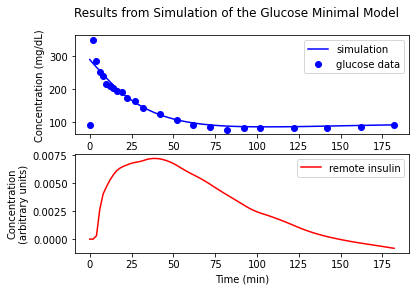

In [14]:
fig, axs = plt.subplots(2);
fig.suptitle('Results from Simulation of the Glucose Minimal Model');
axs[1].plot( results['time'], results['X'], 'r', label = 'remote insulin');
axs[1].legend()
axs[1].set_ylabel('Concentration\n(arbitrary units)')
axs[1].set_xlabel('Time (min)')
axs[0].plot( results['time'], results['G'], 'b', label = 'simulation');
axs[0].plot( data.index, data['glucose'], 'ob', label = 'glucose data');
axs[0].legend();
axs[0].set_ylabel('Concentration (mg/dL)');

### Ralston's Method

&nbsp;&nbsp;&nbsp;&nbsp;Define python objects and functions to implement Ralston's numerical solution:
<br><br>

In [15]:
#use notebook slope & spring-boarding off reference #4
def slope_func( state, t, system ):
    """
    Compute the 1st derivative of the system/state at a given time(t)
    state: 
    """
    G,X = state
    k1, k2, k3 = system.k1, system.k2, system.k3
    I, Ib, Gb = system.I, system.Ib, system.Gb    
    dGdt = -k1*(G-Gb) - X*G
    dXdt = k3*(I(t)-Ib) - k2*X
    return dGdt, dXdt

def ralstonMethod( system, update_func ):
    t = np.arange( system.t_0, system.t_end+system.dt, system.dt )
    n = len(t)
    y = np.zeros((n, len(vars(aSys.initState))))
    init = vars(aSys.initState)
    y[0] = [init['G'], init['X']]
    for i in range(n - 1):
        #print(i)
        # evaluate the slopes at the start of the time step
        slopeNow = slope_func(y[i], i, system)
        #print(slopeNow)
        # evaluate the slopes at the two-thirds point
        ymid = [y + slope * (2*system.dt/3) for y, slope in zip(y[i], slopeNow)]
        slopeLater = slope_func( ymid, i+2 * system.dt / 3, system)
        #print(slopeLater)
        # compute the weighted sum of the slopes
        weightedSlopes = [(k1 + 3 * k2) / 4 for k1, k2 in zip(slopeNow, slopeLater)]
        #print( weightedSlopes)
        # compute the next time stamp
        yNext = [y + slope * system.dt for y, slope in zip(y[i], weightedSlopes)]
        # store the results
        y[i+1]=yNext
        #to dataframe
        data = {'time':t, 'G':y[:,0], 'X':y[:,1]}
        df = pd.DataFrame( data )
    return df


<br>
&nbsp;&nbsp;&nbsp;&nbsp;Run Ralston's method and visualize the results:
<br><br>

In [16]:
result_rk2 = ralstonMethod( aSys, slope_func )

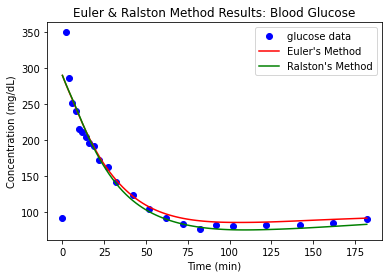

In [17]:
plotRes = result_rk2.set_index('time')

plt.plot( data.index, data['glucose'], 'ob', label = 'glucose data')
plt.plot(results['time'], results['G'], 'r', label = "Euler's Method")
plt.plot(plotRes['G'], 'g', label = "Ralston's Method")
plt.legend()
plt.title('Euler & Ralston Method Results: Blood Glucose')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mg/dL)');

&nbsp;&nbsp;&nbsp;&nbsp;From the figure above, we see that both the Euler & Ralston Methods yield comparable results. The following code will repeat the simulation, but with a smaller time step size. 

In [18]:
aSys1 = make_system( params, data, 1 )
result_rk1 = ralstonMethod( aSys1, slope_func )

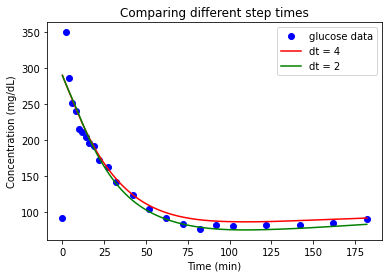

In [19]:
plotRes1 = result_rk1.set_index('time')

plt.plot( data.index, data['glucose'], 'ob', label = 'glucose data')
plt.plot(plotRes1['G'], 'r', label = "dt = 4")
plt.plot(plotRes['G'], 'g', label = "dt = 2")
plt.legend()
plt.title('Comparing different step times')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (mg/dL)');

<br>
&nbsp;&nbsp;&nbsp;&nbsp;define an error function that will return the difference between the results and the data:
<br><br>

In [20]:
def error_func( params, data, timestep ):
    """
    compares results to data and returns an array of errors
    params: a Params() object
    data: dataframe of raw data
    """
    #print( 'params:\n', vars( params ) )
    system = make_system( params, data, timestep )
    results = ralstonMethod( system, update_func )
    Rmatched2Data = results.loc[results['time'].isin(data.index)]
    filterDataIDX = [x for x, val in enumerate(list(data.index)) if val in list(Rmatched2Data['time'])]
    Datamatched2R = data.iloc[filterDataIDX]
    matchedResultsG = list(Rmatched2Data.G)
    matchedDataG = list(Datamatched2R.glucose)
    error = [a_i - b_i for a_i, b_i in zip(matchedResultsG , matchedDataG)]
    return error

In [21]:
error_dt16 = error_func( params, data, 16 )
meansqrs_error_dt16 = sum([x**2 for x in error_dt16])/len(error_dt16)
error_dt8 = error_func( params, data, 8 )
meansqrs_error_dt8 = sum([x**2 for x in error_dt8])/len(error_dt8)
error_dt2 = error_func( params, data, 2 )
meansqrs_error_dt2 = sum([x**2 for x in error_dt2])/len(error_dt2)
error_dt1 = error_func( params, data, 1 )
meansqrs_error_dt1 = sum([x**2 for x in error_dt1])/len(error_dt1)

print('MSE dt = 16', meansqrs_error_dt16, '\nMSE dt = 8', meansqrs_error_dt8, '\nMSE dt = 2:', meansqrs_error_dt2, '\nMSE dt = 1:',meansqrs_error_dt1)

MSE dt = 16 13375.507577781093 
MSE dt = 8 7912.424877470429 
MSE dt = 2: 2075.7148167905452 
MSE dt = 1: 1910.4037406186596


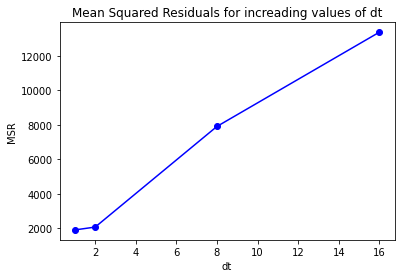

In [22]:
x = [1,2,8,16]
MSEs = [meansqrs_error_dt1, meansqrs_error_dt2, meansqrs_error_dt8, meansqrs_error_dt16]

plt.plot( x, MSEs, 'bo-' )
plt.title( 'Mean Squared Residuals for increading values of dt')
plt.xlabel( 'dt' )
plt.ylabel( 'MSR' );

&nbsp;&nbsp;&nbsp;&nbsp;The figure above plots the increase in Mean Squared Residuals as a function of dt (time step interval). The relationship is clear, as step size increases, more error is introduced to the numerical solution. That is, the larger the step size, the larger the discrepancy between the simulation result and the data.

In [23]:
print(error_dt16)
print(error_dt8)
print(error_dt2)
print(error_dt1)
t1 = np.arange( 0, 182+1, 1 )

[198.0, 21.769599999999997, 21.18035054439082]
[198.0, 8.182400000000001, 11.11365572509203, -0.8740063134946752, -12.918803620314236]
[198.0, -71.52359999999999, -19.49489077077766, 5.882377205235514, 6.01037713936438, 18.7099388333165, 12.526932961028876, 7.71396145843471, 6.422151387691912, 3.0708718456330644, -1.9454351724496632, -7.741799955263943, -4.476006576639122, -1.764972569616333, -0.5543341473482286, 2.134211995641323, -5.3459796757069284, -5.480748602675831, -6.195169353793531, -4.381201623777059, -4.763310207759275, -6.895152876547996]
[198.0, -71.54969947962508, -19.700881428732657, 4.817293742834266, 4.3945563236707414, 17.394310073704986, 11.882736958317224, 7.889599400083284, 7.437945684614363, -1.683367952833919, 6.4380389420725805, -1.849900607936945, 4.638336127337794, 0.282912138853888, 4.136059047880707, 7.320472320788312, 9.110871725834116, 12.44165934066558, 5.50410780711897, 5.718068233644516, 4.848033083142198, 6.358968311137588, 5.138211735104804, 1.7962806

Max error dt = 1: 198.0 
Max error dt = 2: 198.0


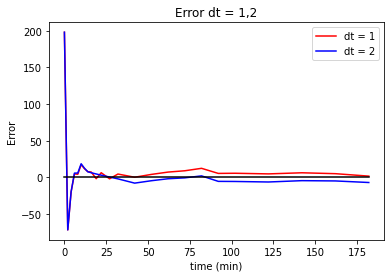

In [24]:
t1 = np.arange( 0, 182+1, 1 )
t2 = np.arange( 0, 182+2, 2 )
t1IDX = np.isin( t1, data.index )
t1 = t1[t1IDX]
t2IDX = np.isin( t2, data.index )
t2 = t2[t2IDX]

plt.plot( t1, error_dt1, 'r', label = 'dt = 1' )
plt.plot( t2, error_dt2, 'b', label = 'dt = 2' )
plt.plot( t1, np.zeros(len(error_dt1)), 'k')
plt.legend()
plt.title( 'Error dt = 1,2')
plt.xlabel( 'time (min)')
plt.ylabel( 'Error');

print( 'Max error dt = 1:', max( error_dt1), '\nMax error dt = 2:', max( error_dt2))

&nbsp;&nbsp;&nbsp;&nbsp;The figure above plots the relative error as a function of time for the data series given a dt = 1 & dt = 2. It is obvious that the largest errors occur at the start of the data series. This is not surprising given the sharp peak in blood glucose concentration at the beginning of data acquisition (due to the glucose injection at the start of the FSIGT test.  
&nbsp;&nbsp;&nbsp;&nbsp;The following code will find the largest relative error between the two solutions:

In [25]:
dt1 = list( result_rk1[ result_rk1.time.isin( result_rk2.time )]['G'] )
dt2 = list( result_rk2['G'] )
diff = [a_i - b_i for a_i, b_i in zip(dt1 , dt2)]
largestRelError = round(max(abs(diff/result_rk2['G']*100)),2)
largestRelError 

14.9

&nbsp;&nbsp;&nbsp;&nbsp;The largest relative difference between the Ralston Method solutions with a dt=1 and a dt=2 is 14.9%. This is a considerably larger difference than between the Euler & Ralston methods given the same dt=2.

### Future Directions
This Notebook implemented & visualized a basic attemp at the Glucose Minimal Model. There are many directions can can push this analysis further:
1. Implement the Minimal Model for blood Insulin concentration
2. Optimize initialization parameters (e.g. using least squares minimization)
3. Higher Order Numerical Solution algorithms to better fit the data (e.g. 4th order Runge-Kutta)
4. Implement a more advanced model of blood glucose/insulin concentration (5)

### Definitions: The Glucose-Insulin System

**Glucose** a form of sugar that circulates in the blood stream of animals and is metabolized as the most common fuel for typical cellular processes.  
**Insulin** a hormone produced by the pancreas that acts to lower blood glucose levels.  
**Hyperglycemia** when blood sugar levels become elevated.
**Hypoglycemia** when blood sugar levels are depressed.
**Diabetes Mellitus** a condition characterized by hyperglycemia because the body does not produce enough insulin &/or does not properly respond to the insulin that the body produces.
**Frequently Sampled Intravenous Glucose Tolerance Test (FSIGT)** one of the most common tests for hyperglycemia &/or diabetes mellitus. a glucose injection is administered to a fasting subject. subsequently, a series of blood samples are drawn in intervals for several hours. from these samples, blood glucose measurements are obtained which describes the subjects ability to metabolize glucose.

## References

1. Bergman, Richard N. "Minimal model: perspective from 2005." Hormone Research in Paediatrics 64.Suppl. 3 (2005): 8-15.
2. [CDC National Diabetes Statistics Report 2020](https://www.cdc.gov/diabetes/pdfs/data/statistics/national-diabetes-statistics-report.pdf)
3. Pacini, Giovanni, and Richard N. Bergman. "MINMOD: a computer program to calculate insulin sensitivity and pancreatic responsivity from the frequently sampled intravenous glucose tolerance test." Computer methods and programs in biomedicine 23.2 (1986): 113-122.
4. [Runge-Kutta methods for ODE integration in Python](https://perso.crans.org/besson/publis/notebooks/Runge-Kutta_methods_for_ODE_integration_in_Python.html)
5. Schmidtke, David W., et al. "Measurement and modeling of the transient difference between blood and subcutaneous glucose concentrations in the rat after injection of insulin." Proceedings of the National Academy of Sciences 95.1 (1998): 294-299.